In [1]:
!pip uninstall pylopt

In [3]:
!pip install ../../artefacts/pylopt-1.0.0-py3-none-any.whl

Processing /home/florianthaler/Documents/research/pylopt/artefacts/pylopt-1.0.0-py3-none-any.whl

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [4]:
import os
import time
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from pathlib import Path

In [5]:
torch.manual_seed(123)

### Setup regulariser (load filter and filter weights from file)

In [6]:
from pylopt.utils.file_system_utils import get_repo_root_path

# set path of directory containing image data and model data 
# NOTE
#   > the function get_repo_root_path() determines the root path of the 
#       project's git repository containing the directories data/images, and
#       data/model_data.
root_path = get_repo_root_path(Path().resolve())

### Setup image dataset

In [7]:
dtype = torch.float32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
from pylopt.dataset.ImageDataset import TestImageDataset
from pylopt.dataset.dataset_utils import collate_function

test_data_root_dir = os.path.join(root_path, 'data', 'images', 'test_images')
test_image_dataset = TestImageDataset(root_path=test_data_root_dir, dtype=dtype)
test_loader = DataLoader(test_image_dataset, batch_size=len(test_image_dataset), shuffle=False,
                         collate_fn=lambda x: collate_function(x, crop_size=-1))

### Setup regulariser

In [12]:
from pylopt.regularisers import FieldsOfExperts, ImageFilter, StudentT

image_filter = ImageFilter.from_file(os.path.join(root_path, 'data', 'model_data', 'filters_7x7_chen-ranftl-pock_2014_scaled.pt'))
potential = StudentT.from_file(os.path.join(root_path, 'data', 'model_data', 'student_t_potential_pylopt_2025_I.pt'))
regulariser = FieldsOfExperts(potential, image_filter)

### Setup measurement model and inner energy

In [13]:
from pylopt.energy import Energy, MeasurementModel

u_clean = list(test_loader)[0]
u_clean = u_clean.to(device=device, dtype=dtype)

noise_level = 0.1
lam = 10

measurement_model = MeasurementModel(u_clean, operator=torch.nn.Identity(), noise_level=noise_level)
energy = Energy(measurement_model, regulariser, lam=lam).to(device=device, dtype=dtype)

### Denoise

In [14]:
from pylopt.utils.Timer import Timer
from pylopt.lower_problem.solve_lower import solve_lower

method = 'nag'
options = {'max_num_iterations': 1000, 
            'rel_tol': 1e-5, 
            'batch_optimisation': False, 
            'lip_const': 1e1,
            'resample_measurement_noise': False}

with Timer(device=device) as t:
    lower_prob_result = solve_lower(energy=energy, method=method, options=options)

print('denoising stats:')
print(' > elapsed time [ms] = {:.5f}'.format(t.time_delta()))
print(' > number of iterations = {:d}'.format(lower_prob_result.num_iterations))
print(' > cause of termination = {:s}'.format(lower_prob_result.message))

denoising stats:
 > elapsed time [ms] = 506.08127
 > number of iterations = 254
 > cause of termination = Converged


 > psnr [dB] = 29.18778


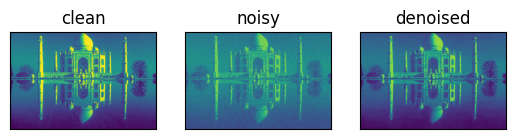

In [15]:
from pylopt.utils.evaluation_utils import compute_psnr

u_clean_splits = torch.split(u_clean, split_size_or_sections=1, dim=0)
u_noisy_splits = torch.split(energy.measurement_model.get_noisy_observation(), split_size_or_sections=1, dim=0)
u_denoised_splits = torch.split(lower_prob_result.solution, split_size_or_sections=1, dim=0)
for idx, (item_clean, item_noisy, item_denoised) in (
        enumerate(zip(u_clean_splits, u_noisy_splits, u_denoised_splits))):
    psnr = compute_psnr(item_clean, item_denoised)
    print(' > psnr [dB] = {:.5f}'.format(psnr.detach().cpu().item()))

    fig = plt.figure()
    ax_clean = fig.add_subplot(1, 3, 1)
    ax_clean.imshow(item_clean.squeeze().detach().cpu().numpy())
    ax_clean.set_title('clean')
    ax_clean.xaxis.set_visible(False)
    ax_clean.yaxis.set_visible(False)

    ax_noisy = fig.add_subplot(1, 3, 2)
    ax_noisy.imshow(item_noisy.squeeze().detach().cpu().numpy())
    ax_noisy.set_title('noisy')
    ax_noisy.xaxis.set_visible(False)
    ax_noisy.yaxis.set_visible(False)

    ax_denoised = fig.add_subplot(1, 3, 3)
    ax_denoised.imshow(item_denoised.squeeze().detach().cpu().numpy())
    ax_denoised.set_title('denoised')
    ax_denoised.xaxis.set_visible(False)
    ax_denoised.yaxis.set_visible(False)

    plt.savefig('denoised_{:d}.png'.format(idx))
    
    plt.show()

